## Applicazione analisi Detection Histories e Modelli Occupancy

### Claudia Gabriela Ochoa Martinez (2020)

In [1]:
#### Inserire l'anno su cui si vuole effettuare l'analisi es. =="2014", "2015", ecc
anno_analisi <- "2018"
sessione_analisi <- "1"

In [2]:
library(dplyr)
library(readr)
library(unmarked)
require(stats4)
require(parallel)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: stats4


Attaching package: 'stats4'


The following object is masked from 'package:unmarked':

    mle


Loading required package: parallel



In [3]:
# Matrice di detection history (catture effettive) -- y
catture_effettive <- read.csv("Dati-preparazione-modello\\catture_effettive_totale.csv", dec=",", sep=";", header = TRUE)

# Leggiamo le matrici dell'Orario (Alba Tramonto), Precipitazioni e Temperatura -- ObsCovs
orario_occasione <- read.csv("Dati-preparazione-modello\\orario_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
precipitazioni_occasione <- read.csv("Dati-preparazione-modello\\precipitazioni_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
temperatura_occasione <- read.csv("Dati-preparazione-modello\\temperatura_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
velvento_occasione <- read.csv("Dati-preparazione-modello\\velvento_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

# Prendiamo Datioccas per legare l'anno alle varie osservazioni
Datioccas <- read.csv("Dati-elaborati/Dati-occasioni.csv", dec=",", sep=";", header = TRUE)

# Leggiamo il file relativo alle invarianti ambientali (covariate) -- siteCovs
siteCovs <- read.csv("Dati-preparazione-modello/Dati-cov-mdr-iqr.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

In [4]:
# Non avendo sufficienti dati sulle ultime 5 trappole, le escludiamo
catture_effettive <- catture_effettive[1:70,]

orario_occasione <- orario_occasione[1:70,]
precipitazioni_occasione <- precipitazioni_occasione[1:70,]
temperatura_occasione <- temperatura_occasione[1:70,]
velvento_occasione <- velvento_occasione[1:70,]
siteCovs <- siteCovs[1:70,]

In [5]:
# TRASFORMIAMO le specie vegetali presenti in siteCovs in numeric per evitare singolarità nei modelli
siteCovs$dominant[siteCovs$dominant != "Graminacee" & siteCovs$dominant != "Muschio"]  <- 30
siteCovs$dominant[siteCovs$dominant == "Graminacee"]  <- 20
siteCovs$dominant[siteCovs$dominant == "Muschio"]  <- 10
siteCovs$dominant <- as.numeric(siteCovs$dominant)

# Seleziono la coperatura vegetale di interesse
if (anno_analisi %in% c("2014","2015","2016","2017")) {
    siteCovs$cop_veg_ottavi <- siteCovs$Cop_Veg_2015_ottavi
    siteCovs <- subset(siteCovs, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))
} else {
    siteCovs$cop_veg_ottavi <- siteCovs$Cop_Veg_2018_ottavi
    siteCovs <- subset(siteCovs, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))

}
    
tail(siteCovs)

,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,dominant,MDR,IQR,Esp.tr,cop_veg_ottavi
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>
65,292,99,67,2787.358,13,7,2,10,99,112.5,13,NA
66,139,75,21,2788.498,11,29,14,30,75,59.0,11,NA
67,77,83,40,2792.428,19,38,13,20,77,21.5,19,NA
68,71,127,58,2794.777,13,17,10,30,71,34.5,13,NA
69,97,75,66,2792.266,12,11,8,20,75,15.5,12,NA
70,207,73,96,2792.857,358,2,2,30,96,67.0,-2,NA


In [6]:
# Ricaviamo le colonne oggetto di analisi
if (exists("sessione_analisi")) {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi & sessione == sessione_analisi))
} else {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi))
}
colonne_oggetto_analisi <- as.numeric(colonne_oggetto_analisi)

In [7]:
catture_effettive_selezionate <- catture_effettive[,colonne_oggetto_analisi]

In [8]:
summary(siteCovs)

 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   : 30.00         Min.   : 28.00         Min.   :  8.00        
 1st Qu.: 67.25         1st Qu.: 44.00         1st Qu.: 40.00        
 Median : 97.00         Median : 62.00         Median : 56.50        
 Mean   :118.70         Mean   : 75.06         Mean   : 69.66        
 3rd Qu.:139.75         3rd Qu.: 92.50         3rd Qu.: 75.50        
 Max.   :440.00         Max.   :308.00         Max.   :292.00        
                                                                     
     alt_m        aspect_deg      slope_degr      n_species        dominant    
 Min.   :2778   Min.   :  0.0   Min.   : 0.00   Min.   : 0.00   Min.   :10.00  
 1st Qu.:2783   1st Qu.: 59.0   1st Qu.: 7.25   1st Qu.:10.25   1st Qu.:20.00  
 Median :2789   Median :314.5   Median :11.50   Median :15.00   Median :20.00  
 Mean   :2789   Mean   :239.4   Mean   :13.04   Mean   :15.59   Mean   :20.14  
 3rd Qu.:2795   3rd Qu.:332.0   3rd Qu.:

#### Concludiamo che tutte le variabili presenti in siteCovs sono adatte ad essere utilizzate nell'analisi
#### Provvediamo a scalarle e centrarle

In [9]:
siteCovs <- data.frame(scale(siteCovs))
tail(siteCovs)

,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,dominant,MDR,IQR,Esp.tr,cop_veg_ottavi
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
65,2.3221655,0.508714136,-0.05028955,-0.2773832,-1.6601337,-0.6973735,-1.7814483,-1.51357553,0.75023962,1.7135977,0.9721058,NA
66,0.2720136,-0.001214115,-0.92089358,-0.1254769,-1.6747964,1.8415278,-0.2079293,1.47093960,0.02587033,0.2800171,0.9178632,NA
67,-0.5587669,0.168761969,-0.56129626,0.3982001,-1.6161456,2.8801692,-0.3390559,-0.02131797,0.08623444,-0.7248291,1.1348338,NA
68,-0.6391650,1.103630428,-0.22062512,0.7112070,-1.6601337,0.4566725,-0.7324356,1.47093960,-0.09485788,-0.3764824,0.9721058,NA
69,-0.2907732,-0.001214115,-0.06921572,0.3766134,-1.6674651,-0.2357551,-0.9946888,-0.02131797,0.02587033,-0.8856045,0.9449845,NA
70,1.1831922,-0.043708136,0.49856951,0.4553648,0.8691849,-1.2743966,-1.7814483,1.47093960,0.65969346,0.4943843,0.5652859,NA


In [10]:
summary(t(orario_occasione[1,colonne_oggetto_analisi]))
summary(t(precipitazioni_occasione[1,colonne_oggetto_analisi]))
summary(t(temperatura_occasione[1,colonne_oggetto_analisi]))
summary(t(velvento_occasione[1,colonne_oggetto_analisi]))


  1     
 Al:10  
 Tr: 9  

       1          
 Min.   :0.00000  
 1st Qu.:0.00000  
 Median :0.00000  
 Mean   :0.05263  
 3rd Qu.:0.00000  
 Max.   :1.00000  

       1        
 Min.   : 8.50  
 1st Qu.:12.35  
 Median :13.60  
 Mean   :13.59  
 3rd Qu.:15.15  
 Max.   :17.40  

       1        
 Min.   :0.600  
 1st Qu.:1.150  
 Median :1.600  
 Mean   :1.626  
 3rd Qu.:1.950  
 Max.   :2.900  

#### La variabile relativa alle precipitazioni, nel 2015, è inadatta alle analisi, verrà automaticamente scartata dal modello
#### Le variabili categoriche non possono essere scalate (orario_ooccasione)
#### La variabile temperatura_occasione è inadatta ad essere scalata

In [11]:
obsCovs <- list(
    orario = orario_occasione[,colonne_oggetto_analisi],
    precip = precipitazioni_occasione[,colonne_oggetto_analisi],
    temper = temperatura_occasione[,colonne_oggetto_analisi],
    vento = velvento_occasione[,colonne_oggetto_analisi]

)


In [12]:
arvicole <- unmarkedFrameOccu(y = catture_effettive_selezionate, siteCovs = siteCovs, obsCovs = obsCovs)
summary(arvicole)

unmarkedFrame Object

70 sites
Maximum number of observations per site: 19 
Mean number of observations per site: 19 
Sites with at least one detection: 17 

Tabulation of y observations:
   0    1 
1301   29 

Site-level covariates:
 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   :-1.1886        Min.   :-0.9998        Min.   :-1.1669       
 1st Qu.:-0.6894        1st Qu.:-0.6599        1st Qu.:-0.5613       
 Median :-0.2908        Median :-0.2774        Median :-0.2490       
 Mean   : 0.0000        Mean   : 0.0000        Mean   : 0.0000       
 3rd Qu.: 0.2821        3rd Qu.: 0.3706        3rd Qu.: 0.1106       
 Max.   : 4.3053        Max.   : 4.9493        Max.   : 4.2081       
                                                                     
     alt_m            aspect_deg        slope_degr        n_species      
 Min.   :-1.53434   Min.   :-1.7554   Min.   :-1.5052   Min.   :-2.0437  
 1st Qu.:-0.91819   1st Qu.:-1.3229   1st Qu.:-0.6685   1s

In [16]:
# n_species potremmo ignorarlo poiché fortemente correlato con la copertura veg. del 2015
# slope_degr potremmo ignorarlo ignorato poiché trasformato in Esp.tr
#    occu(~P            # PROBABILITA' DI AVVISTAMENTO
#         ~PSI,         # EFFETTIVA PRESENZA
#          dataset)
fm.base <- occu(~orario + temper + vento + MDR
            ~MDR + I(MDR^2) +
            IQR + I(IQR^2) +
            Esp.tr + I(Esp.tr^2)+
            cop_veg_ottavi + I(cop_veg_ottavi^2) +
            alt_m + I(alt_m^2) +
            dominant + I(dominant^2) +
            #n_species + I(n_species^2) +
            slope_degr + I(slope_degr^2),
            arvicole)

Warning message:
"Some observations have been discarded because corresponding covariates were missing."
Warning message:
"20 sites have been discarded because of missing data."


In [17]:
######### INFORMATICA
clusterType <- if(length(find.package("snow", quiet = TRUE))) "SOCK" else "PSOCK"
clusterType
clust <- try(makeCluster(getOption("cl.cores", 2), type = clusterType))
clusterEvalQ(clust, library(unmarked))
clusterEvalQ(clust,library(MuMIn))
clusterExport(clust, "arvicole")
invisible(clusterCall(clust, "library", "stats4", character.only = TRUE))
library(MuMIn)
getAllTerms(fm.base)

[1] "SOCK"

[[1]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"

[[1]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"

[1] "p(MDR)"                   "p(orario)"               
 [3] "p(temper)"                "p(vento)"                
 [5] "psi(alt_m)"               "psi(I(alt_m^2))"         
 [7] "psi(cop_veg_ottavi)"      "psi(I(cop_veg_ottavi^2))"
 [9] "psi(dominant)"            "psi(I(dominant^2))"      
[11] "psi(Esp.tr)"              "psi(I(Esp.tr^2))"        
[13] "psi(IQR)"                 "psi(I(IQR^2))"           
[15] "psi(MDR)"                 "psi(I(MDR^2))"           
[17] "psi(slope_degr)"          "psi(I(slope_degr^2))"    
attr(,"intercept")
  p psi 
  1   1 
attr(,"interceptLabel")
[1] "p(Int)"   "psi(Int)"
attr(,"deps")
                         p(MDR) p(orario) p(temper) p(vento) psi(alt_m)
p(MDR)                       NA     FALSE     FALSE    FALSE      FALSE
p(orario)                 FALSE        NA     FALSE    FALSE      FALSE
p(temper)                 FALSE     FALSE        NA    FALSE      FALSE
p(vento)                  FALSE     FALSE     FALSE       NA      FALSE
psi(alt_m)                FALSE     FALSE     FALSE    FALSE         NA
psi(I(alt_m^2))           FALSE     FALSE     FALSE    FALSE      FALSE
psi(cop_veg_ottavi)       FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(cop_veg_ottavi^2))  FALSE     FALSE     FALSE    FALSE      FALSE
psi(dominant)             FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(dominant^2))        FALSE     FALSE     FALSE    FALSE      FALSE
psi(Esp.tr)               FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(Esp.tr^2))          FALSE     FALSE     FALSE    FALSE      FALSE
psi(IQR)                  FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(IQR^2))             FALSE     FALSE     FALSE    FALSE      FALSE
psi(MDR)                  FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(MDR^2))             FALSE     FALSE     FALSE    FALSE      FALSE
psi(slope_degr)           FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(slope_degr^2))      FALSE     FALSE     FALSE    FALSE      FALSE
                         psi(I(alt_m^2)) psi(cop_veg_ottavi)
p(MDR)                             FALSE               FALSE
p(orario)                          FALSE               FALSE
p(temper)                          FALSE               FALSE
p(vento)                           FALSE               FALSE
psi(alt_m)                         FALSE               FALSE
psi(I(alt_m^2))                       NA               FALSE
psi(cop_veg_ottavi)                FALSE                  NA
psi(I(cop_veg_ottavi^2))           FALSE               FALSE
psi(dominant)                      FALSE               FALSE
psi(I(dominant^2))                 FALSE               FALSE
psi(Esp.tr)                        FALSE               FALSE
psi(I(Esp.tr^2))                   FALSE               FALSE
psi(IQR)                           FALSE               FALSE
psi(I(IQR^2))                      FALSE               FALSE
psi(MDR)                           FALSE               FALSE
psi(I(MDR^2))                      FALSE               FALSE
psi(slope_degr)                    FALSE               FALSE
psi(I(slope_degr^2))               FALSE               FALSE
                         psi(I(cop_veg_ottavi^2)) psi(dominant)
p(MDR)                                      FALSE         FALSE
p(orario)                                   FALSE         FALSE
p(temper)                                   FALSE         FALSE
p(vento)                                    FALSE         FALSE
psi(alt_m)                                  FALSE         FALSE
psi(I(alt_m^2))                             FALSE         FALSE
psi(cop_veg_ottavi)                         FALSE         FALSE
psi(I(cop_veg_ottavi^2))                       NA         FALSE
psi(dominant)                               FALSE            NA
psi(I(dominant^2))                          FALSE         FALSE
psi(Esp.tr)                                 FALSE         FALSE
psi(I(Esp.tr^2))                            FALSE         FALSE
psi(IQR)  

In [18]:
pdd2 <- pdredge(fm.base, clust,
                subset = 
                (`psi(alt_m)` | ! `psi(I(alt_m^2))`) &&
                (`psi(cop_veg_ottavi)` | ! `psi(I(cop_veg_ottavi^2))`) &&
                (`psi(dominant)` | ! `psi(I(dominant^2))`) &&
                (`psi(Esp.tr)` | ! `psi(I(Esp.tr^2))`) &&
                (`psi(IQR)` | ! `psi(I(IQR^2))`) &&
                (`psi(MDR)` | ! `psi(I(MDR^2))`) &&
                #(`psi(n_species)` | ! `psi(I(n_species^2))`) &&
                (`psi(slope_degr)` | !`psi(I(slope_degr^2))`) &&
                `p(MDR)` &&
                `p(orario)` &&
                `p(temper)` &&
                `p(vento)`,    
                trace = 2, m.lim = c(1,NA))

Fixed terms are "p(Int)" and "psi(Int)"



  |======================================================================| 100%


Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"
Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"
Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"
Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"


,p(Int),psi(Int),p(MDR),p(orario),p(temper),p(vento),psi(alt_m),psi(I(alt_m^2)),psi(cop_veg_ottavi),psi(I(cop_veg_ottavi^2)),...,psi(I(IQR^2)),psi(MDR),psi(I(MDR^2)),psi(slope_degr),psi(I(slope_degr^2)),df,logLik,AICc,delta,weight
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<mdl.wght>
17487,0.1449747,197.14386,-1.4212589,+,-0.2209463,-0.2604266,NA,NA,-133.68073,NA,...,NA,470.85883,NA,NA,NA,9,-104.6673,231.8346,0.0000000,0.29667927
1407,0.3288501,257.53558,-0.8984463,+,-0.2205068,-0.2546954,-70.82926,-260.4415,-576.24239,NA,...,NA,NA,NA,NA,NA,11,-101.8186,232.5846,0.7499739,0.20390714
49231,0.2264305,32.29032,-0.5624323,+,-0.2164031,-0.2481803,NA,NA,-37.21219,NA,...,NA,-20.18812,-84.55679,NA,NA,9,-105.1984,232.8967,1.0621439,0.17443980
19583,0.3579867,151.17215,-1.1171667,+,-0.2224198,-0.2573544,39.26078,-130.1932,-123.66281,NA,...,NA,133.07567,NA,NA,NA,12,-100.4327,233.2979,1.4632989,0.14273678
83071,0.3409767,153.38248,-1.0979371,+,-0.2219306,-0.2568116,14.16013,-122.4030,-136.60135,NA,...,NA,144.43486,NA,26.971815,NA,12,-100.8249,234.0823,2.2477244,0.09642731
66943,0.3802129,263.95025,-0.8228389,+,-0.2209419,-0.2554115,-89.54028,-269.2714,-612.33039,NA,...,NA,NA,NA,6.248027,NA,12,-100.9416,234.3156,2.4810391,0.08580971


Warning message:
"Some observations have been discarded because corresponding covariates were missing."
Warning message:
"20 sites have been discarded because of missing data."


$`1407`

Call:
occu(formula = ~MDR + orario + temper + vento + 1 ~ alt_m + I(alt_m^2) + 
    cop_veg_ottavi + dominant + Esp.tr + 1, data = arvicole)

Occupancy:
               Estimate    SE     z P(>|z|)
(Intercept)       257.5 220.7  1.17   0.243
alt_m             -70.8  65.2 -1.09   0.277
I(alt_m^2)       -260.4 223.4 -1.17   0.244
cop_veg_ottavi   -576.2 495.6 -1.16   0.245
dominant          267.2 231.9  1.15   0.249
Esp.tr           -251.6 216.6 -1.16   0.245

Detection:
            Estimate     SE      z P(>|z|)
(Intercept)    0.329 1.1424  0.288  0.7734
MDR           -0.898 0.4049 -2.219  0.0265
orarioTr       0.166 0.4396  0.377  0.7064
temper        -0.221 0.0865 -2.551  0.0108
vento         -0.255 0.3796 -0.671  0.5022

AIC: 225.6372 

attr(,"rank")
function (x) 
do.call("rank", list(x))
<environment: 0x0000000008999c38>
attr(,"call")
AICc(x)
attr(,"class")
[1] "function"     "rankFunction"
attr(,"beta")
[1] "none"

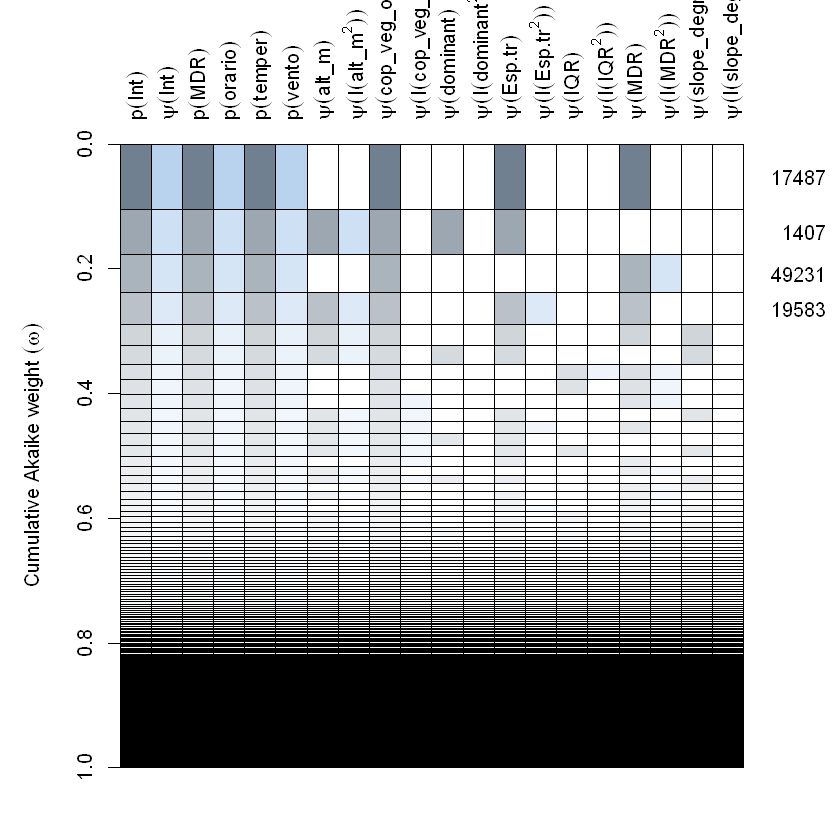

In [20]:
head(pdd2)
par(mfrow = c(1,1))
op <- par(mar = c(3,5,6,4), mfrow=c(1,1))
plot(pdd2, labAsExpr = TRUE)
par(op)

get.models(pdd2,2)

In [ ]:
#save(pdd2, file="Dati-elaborati/pdd2.RData", compress=FALSE)
#load("Dati-elaborati/pdd2.RData")

In [21]:
## PASSAGGIO DI MODEL AVERAGING: CONSIDERIAMO CONTEMPORANEAMENTE I MODELLI MIGLIORI CHE DIFFERISCONO TRA LORO
## DI POCO IN TERMINI DI AIC (deltaAIC < 2)
summary(model.avg(pdd2, subset = delta < 2))


Call:
model.avg(object = pdd2, subset = delta < 2)

Component model call: 
occu(formula = ~<4 unique rhs>, data = arvicole)

Component models: 
                      df  logLik   AICc delta weight
1/2/3/4/7/9/11         9 -104.67 231.83  0.00   0.36
1/2/3/4/5/6/7/8/9     11 -101.82 232.58  0.75   0.25
1/2/3/4/7/11/12        9 -105.20 232.90  1.06   0.21
1/2/3/4/5/6/7/9/10/11 12 -100.43 233.30  1.46   0.17

Term codes: 
             p(MDR)           p(orario)           p(temper)            p(vento) 
                  1                   2                   3                   4 
         psi(alt_m)     psi(I(alt_m^2)) psi(cop_veg_ottavi)       psi(dominant) 
                  5                   6                   7                   8 
        psi(Esp.tr)    psi(I(Esp.tr^2))            psi(MDR)       psi(I(MDR^2)) 
                  9                  10                  11                  12 

Model-averaged coefficients:  
(full average) 
                      Estimate Std. Error 

In [31]:
best.mod1 <- (get.models(pdd2, 2)[[1]])
best.mod1

Warning message:
"Some observations have been discarded because corresponding covariates were missing."
Warning message:
"20 sites have been discarded because of missing data."



Call:
occu(formula = ~MDR + orario + temper + vento + 1 ~ alt_m + I(alt_m^2) + 
    cop_veg_ottavi + dominant + Esp.tr + 1, data = arvicole)

Occupancy:
               Estimate    SE     z P(>|z|)
(Intercept)       257.5 220.7  1.17   0.243
alt_m             -70.8  65.2 -1.09   0.277
I(alt_m^2)       -260.4 223.4 -1.17   0.244
cop_veg_ottavi   -576.2 495.6 -1.16   0.245
dominant          267.2 231.9  1.15   0.249
Esp.tr           -251.6 216.6 -1.16   0.245

Detection:
            Estimate     SE      z P(>|z|)
(Intercept)    0.329 1.1424  0.288  0.7734
MDR           -0.898 0.4049 -2.219  0.0265
orarioTr       0.166 0.4396  0.377  0.7064
temper        -0.221 0.0865 -2.551  0.0108
vento         -0.255 0.3796 -0.671  0.5022

AIC: 225.6372 